<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Computação em Nuvem II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>AWS Lambda;</li>
  <li>AWS Step Functions;</li>
  <li>AWS EventBridge.</li>
</ol>

---

# **Exercícios**

## 1\. AWS Lambda

Replique as atividades do item 1.3 em sua conta.

* Criação **Bronze**

In [ ]:
import json
import logging
from datetime import datetime
import boto3
import urllib3
from botocore.exceptions import ClientError

def lambda_handler(event, context) -> bool:

    # -- setup
    URL = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=01/07/2024&dataFinal=01/07/2024'
    BRONZE_BUCKET = 'm38-ebac-alex-bronze'

    client = boto3.client('s3')

    date = datetime.now().strftime('%Y-%m-%d')
    filename_json = f'stock-exchange-{date}.json'

    # -- extract
    try:
        http = urllib3.PoolManager()
        response = http.request(url=URL, method='GET')
    except Exception as exc:
        raise exc
    else:
        data = json.loads(response.data.decode())
        logging.info(msg=data)

    # -- transform
    if data:
        today_data = data[0]  # Assumindo apenas um registro para a data especificada
        transformed_data = {}
        transformed_data['taxa'] = today_data['valor'].replace(',', '.')
        transformed_data['dataTaxa'] = datetime.strptime(today_data['data'], '%d/%m/%Y').strftime('%Y-%m-%d')
        transformed_data['indice'] = float(today_data['valor']) * 1000  # Exemplo de transformação para obter um índice
        transformed_data['dataIndice'] = transformed_data['dataTaxa']
        transformed_data['dataReferencia'] = datetime.now().strftime('%Y-%m-%d')

        transformed_data['indice'] = f"{transformed_data['indice']:.2f}".replace('.', ',')

    else:
        logging.warning("No data available for the given date.")
        return json.dumps(dict(status=False))

    # -- load
    try:
        with open(f'/tmp/{filename_json}', mode='w', encoding='utf8') as fp:
            json.dump(transformed_data, fp)
        client.upload_file(Filename=f'/tmp/{filename_json}', Bucket=BRONZE_BUCKET, Key=filename_json)
    except ClientError as exc:
        raise exc

    return json.dumps(dict(status=True))

* **Teste**

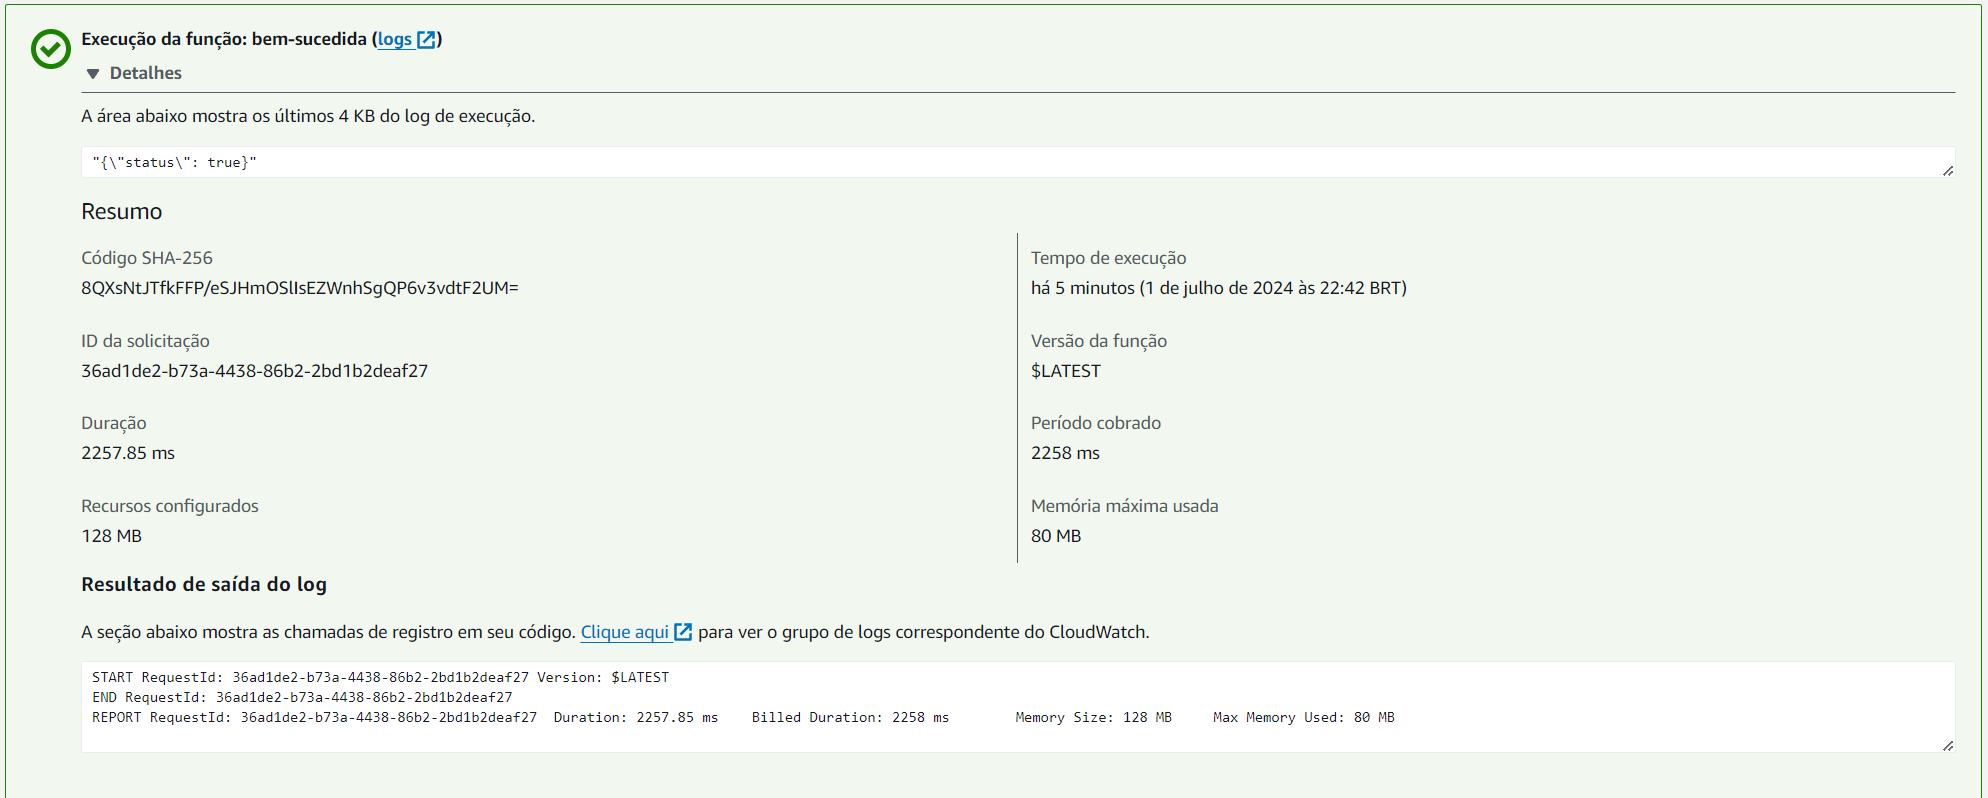

* Criação **Silver**

In [ ]:
import json
from datetime import datetime
import boto3
from botocore.exceptions import ClientError

def lambda_handler(event, context) -> bool:

    # -- setup
    BRONZE_BUCKET = 'm38-ebac-alex-bronze'
    SILVER_BUCKET = 'm38-ebac-alex-silver'

    client = boto3.client('s3')

    date = datetime.now().strftime('%Y-%m-%d')
    filename_csv = f'stock-exchange-{date}.csv'
    filename_json = f'stock-exchange-{date}.json'

    # -- extract
    try:
        client.download_file(BRONZE_BUCKET, filename_json, f'/tmp/{filename_json}')

        with open(f"/tmp/{filename_json}", mode='r', encoding='utf8') as fp:
            data = json.load(fp)

    except ClientError as exc:
        raise exc

    # -- transform
    data['taxa'] = data['taxa'].replace(',', '.')
    data['indice'] = data['indice'].replace('.', '').replace(',', '.')

    # Os campos de data já devem estar no formato correto ('%Y-%m-%d'), então não precisamos transformá-los novamente
    data['dataReferencia'] = datetime.now().strftime('%Y-%m-%d')

    # -- load
    try:
        with open(f'/tmp/{filename_csv}', mode='w', encoding='utf8') as fp:
            fp.write(','.join([str(v) for v in data.values()]))
        client.upload_file(Filename=f'/tmp/{filename_csv}', Bucket=SILVER_BUCKET, Key=f'data_referencia={date}/{filename_csv}')
    except ClientError as exc:
        raise exc

    return json.dumps(dict(status=True))

* **Teste**

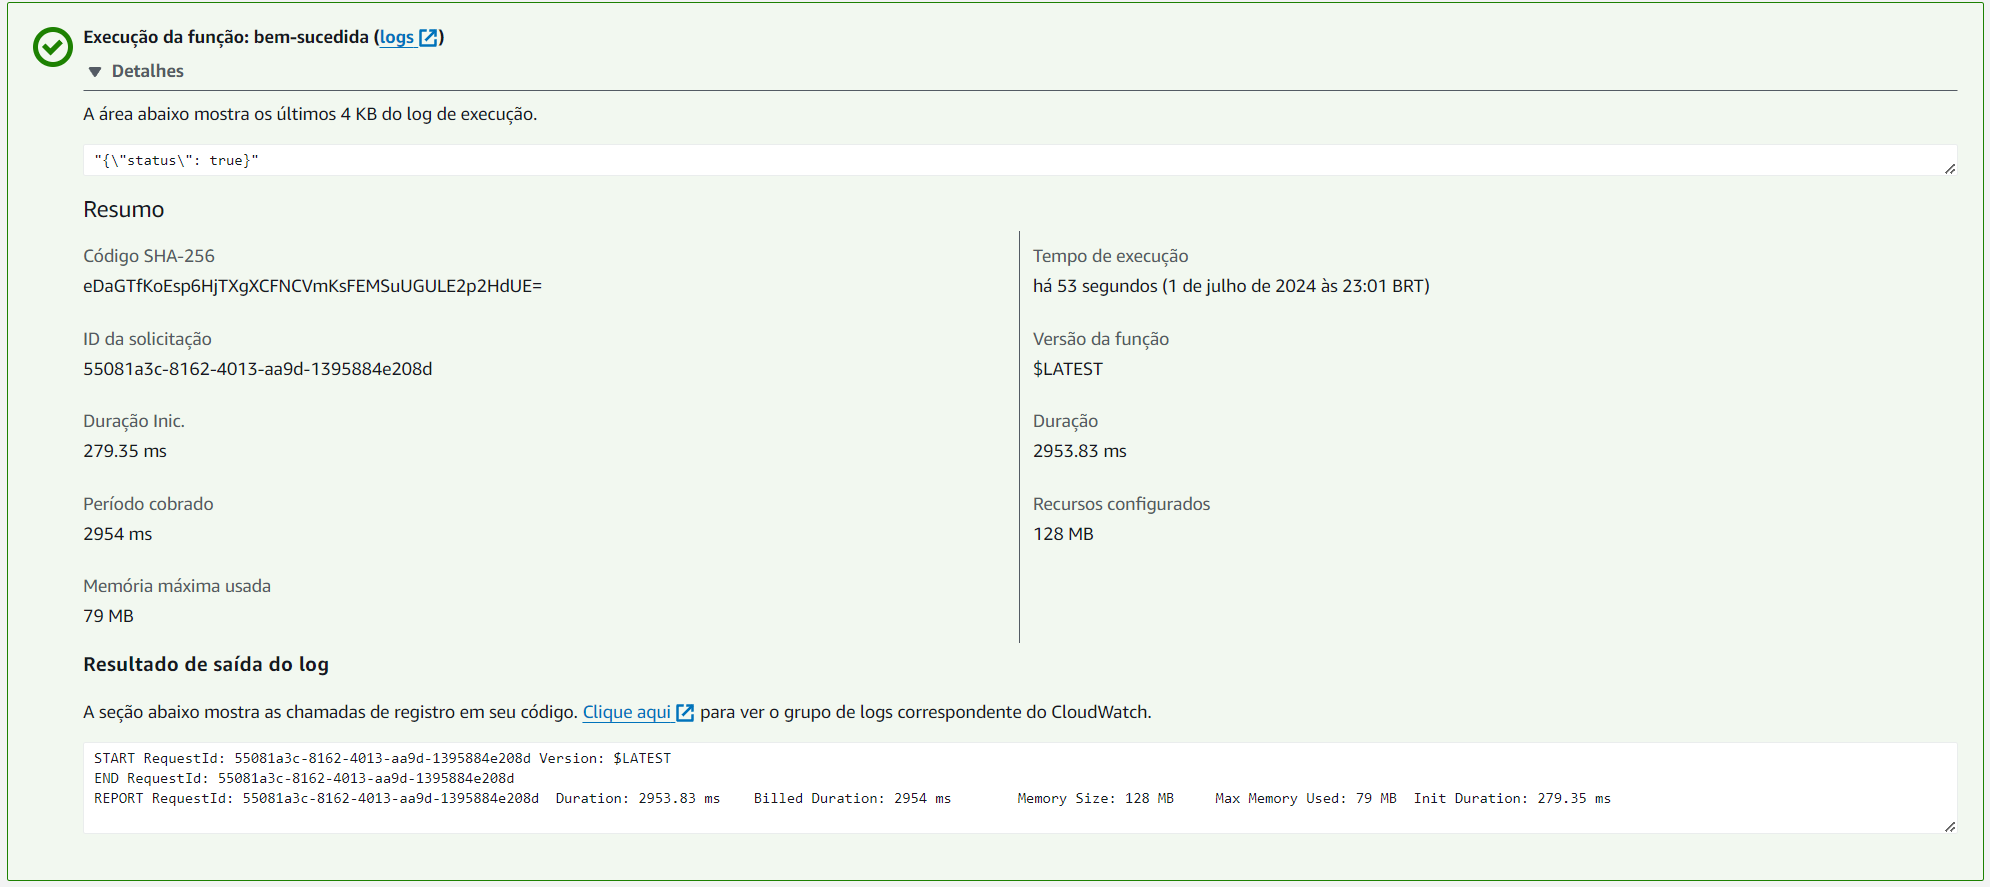

* Criação **Tabela**

In [ ]:
import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  SILVER_BUCKET = 'm38-ebac-alex-silver'

  query = f"""
  CREATE EXTERNAL TABLE IF NOT EXISTS cdi (
    taxa double,
    data_taxa string,
    indice double,
    data_indice string
  )
  PARTITIONED BY (
    data_referencia string
  )
  ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
  WITH SERDEPROPERTIES ('separatorChar'=',')
  LOCATION 's3://{SILVER_BUCKET}/'
  """

  client = boto3.client('athena')

  # -- create

  try:
    client.start_query_execution(
      QueryString=query,
      ResultConfiguration={'OutputLocation': 's3://m38-ebac-alex-results/'}
    )
  except ClientError as exc:
    raise exc

  # -- update

  try:
    client.start_query_execution(
      QueryString='MSCK REPAIR TABLE cdi',
      ResultConfiguration={'OutputLocation': 's3://m38-ebac-alex-results/'}
    )
  except ClientError as exc:
    raise exc

  return json.dumps(dict(status=True))

* **Teste**

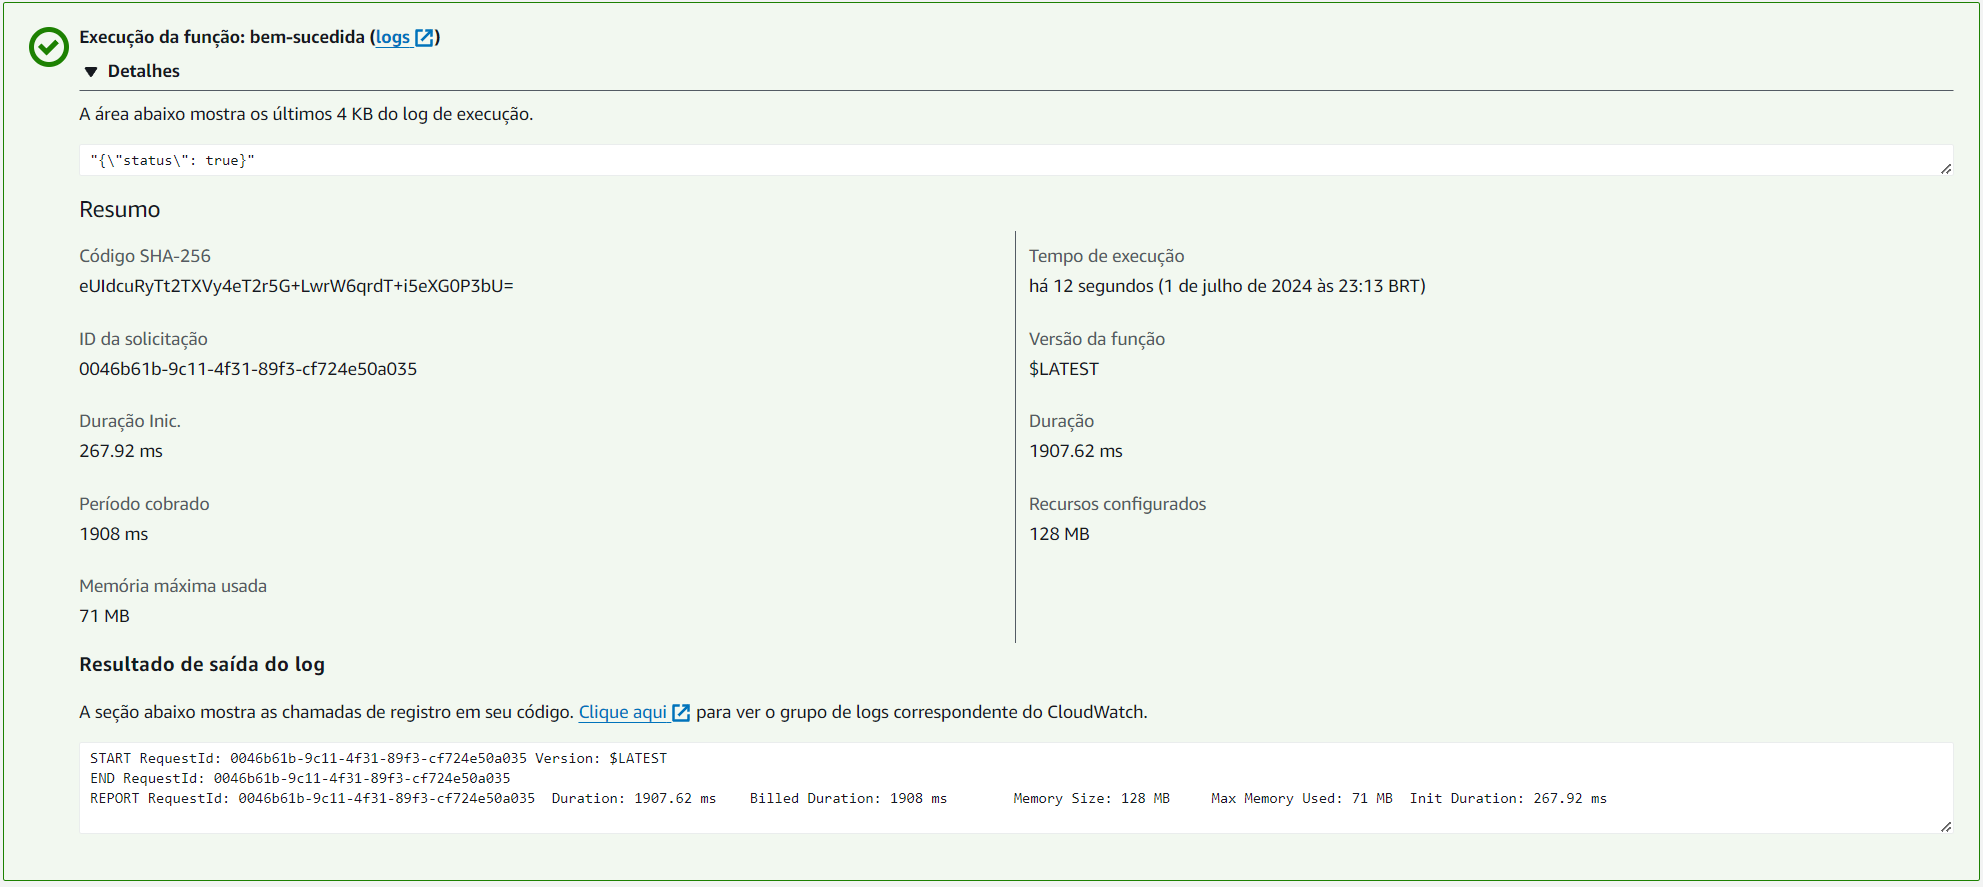

## 2\. AWS Step Functions

Replique as atividades do item 2.3 em sua conta.


* **Criação**

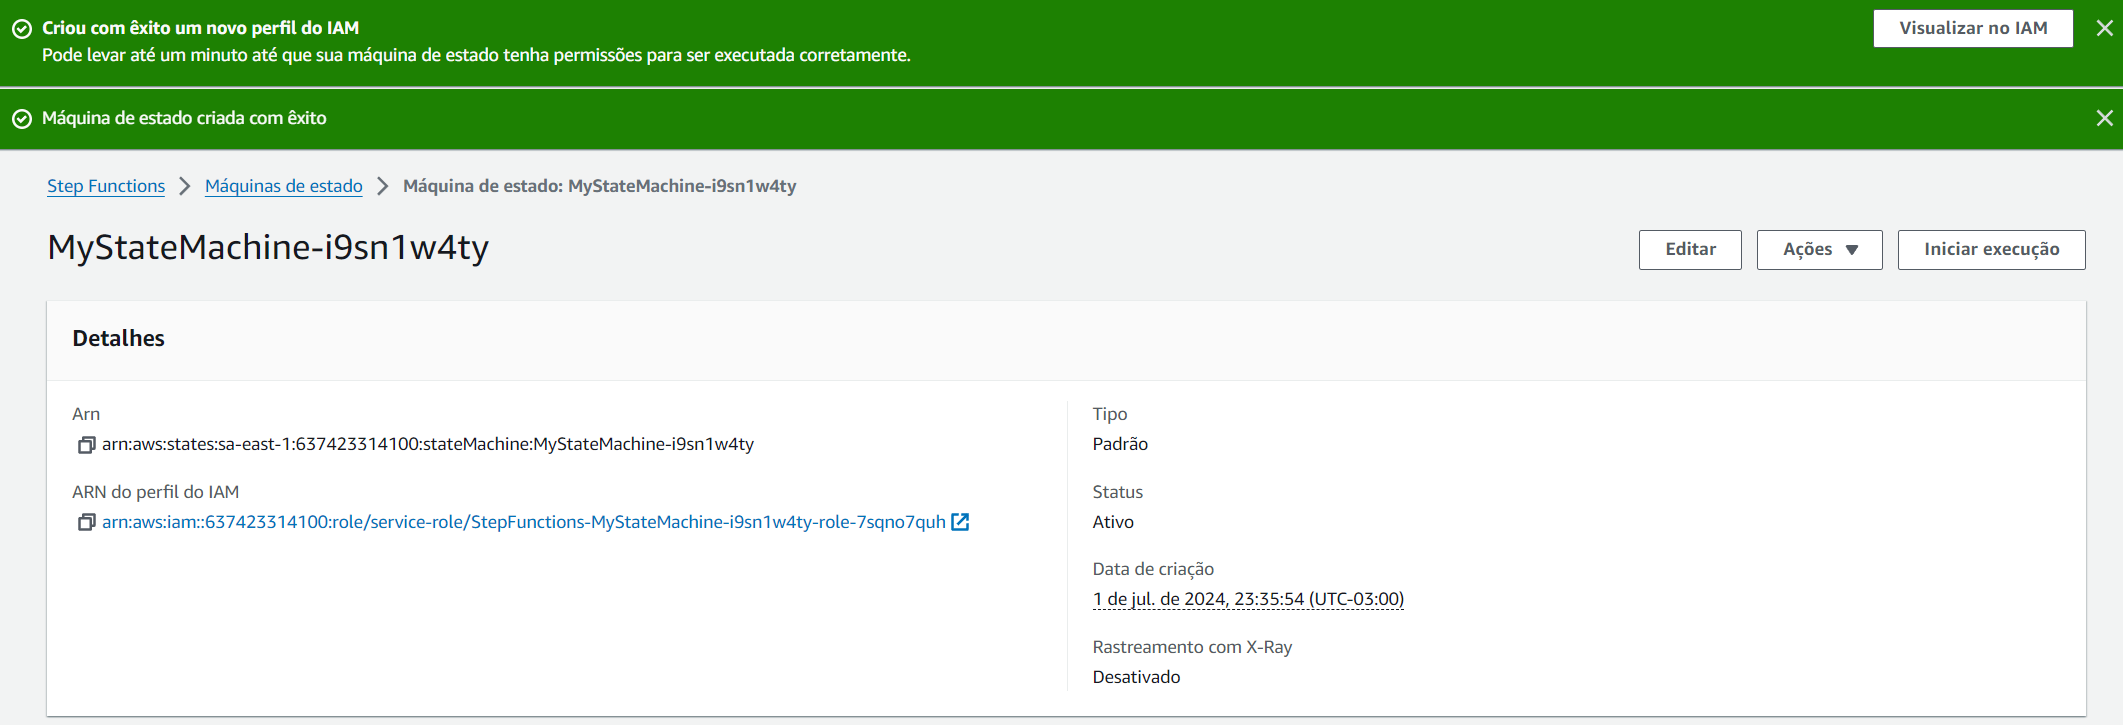

* **Teste**

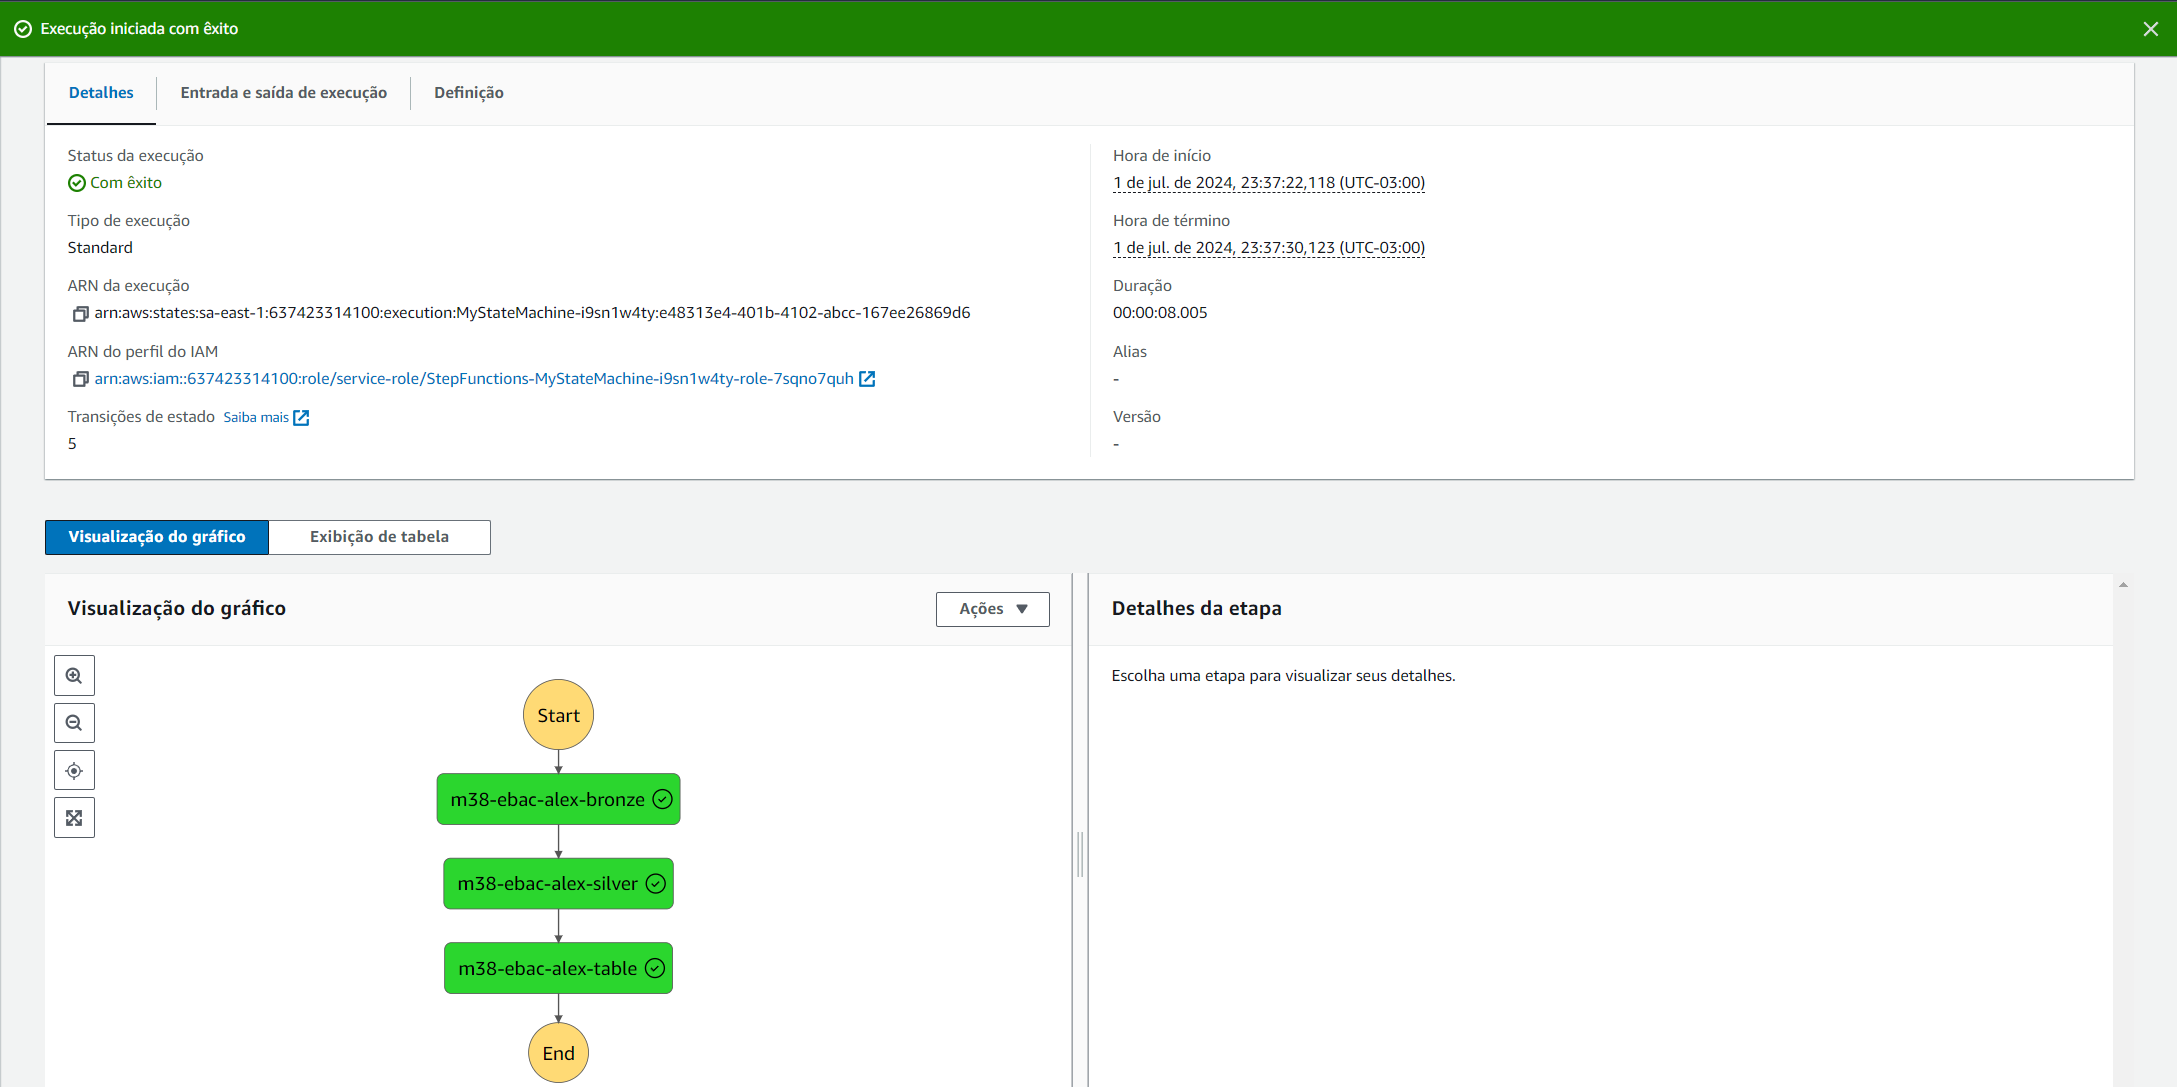

## 3\. AWS EventBridge

Replique as atividades do item 3.3 em sua conta.

* **Criação**

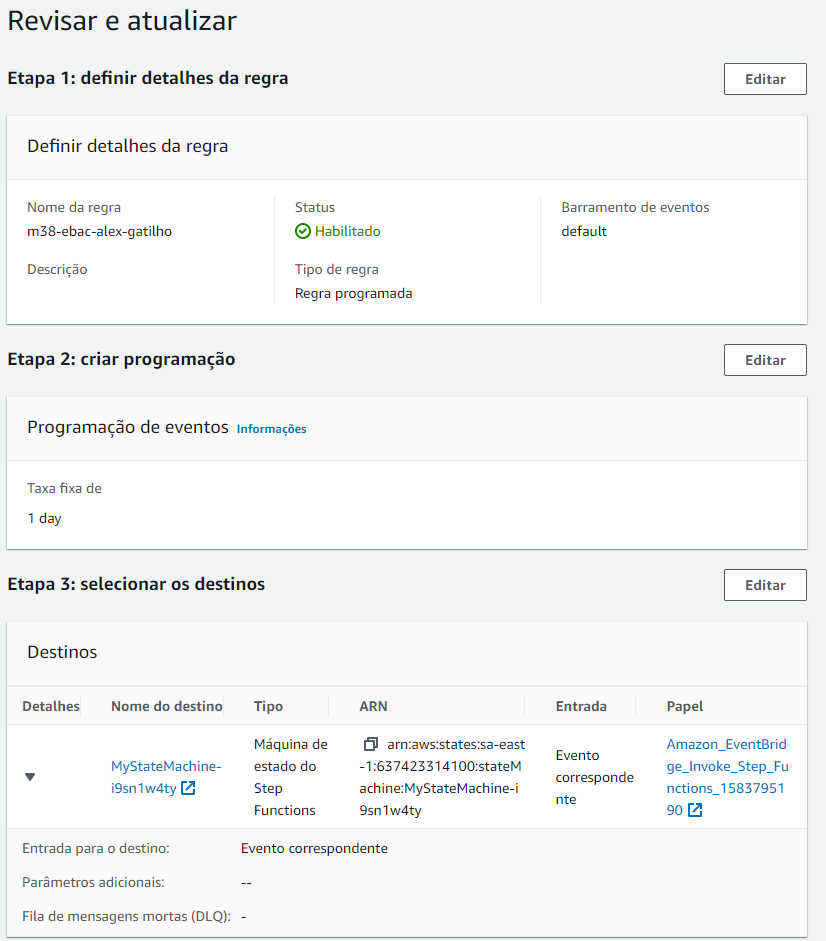

* **Verificação**

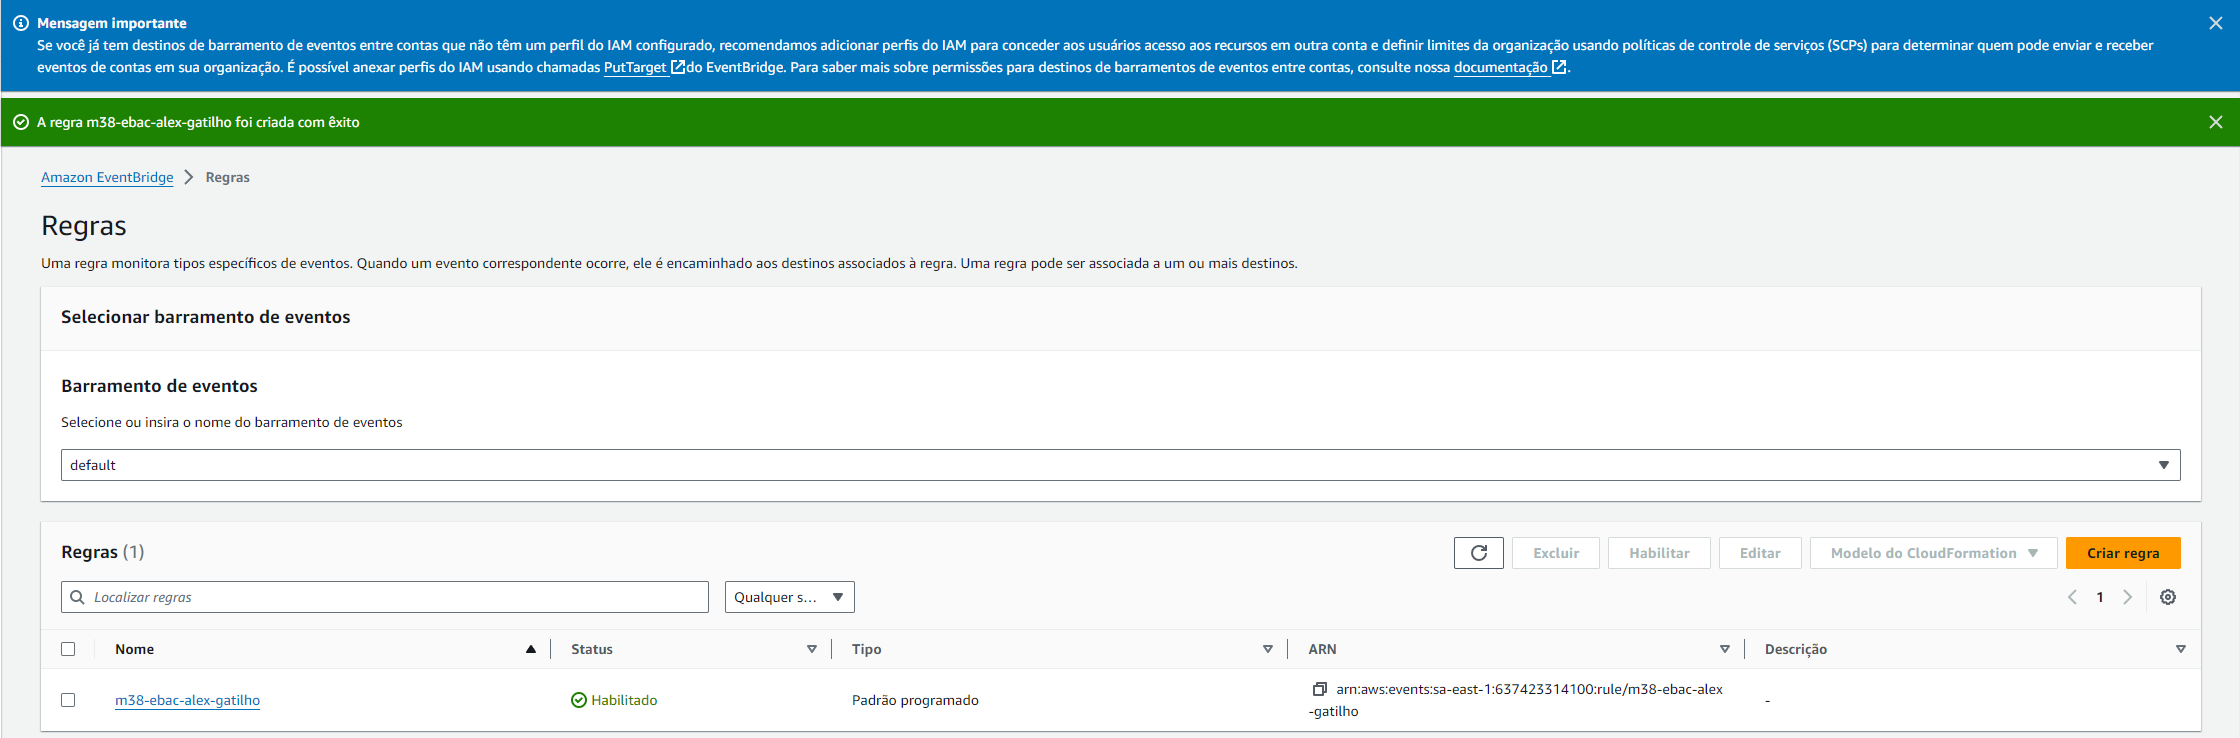